# Analysis pipeline for Specificity

## Preliminaries

In [2]:
%cd ~/code/textrec/

/Users/kcarnold/code/textrec


In [3]:
%matplotlib inline
import datetime
import json
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import toolz
from IPython.display import Image, HTML

In [4]:
from textrec.paths import paths
from textrec import analysis_util, util, notebook_util, automated_analyses
reload(analysis_util), reload(util), reload(notebook_util), reload(automated_analyses)
from textrec.notebook_util import images, id2img, id2url, show_images

Loading COCO captions
Loading COCO id2url
Done


/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading ONMT models...
coco_lm_adam_acc_46.00_ppl_16.32_e10_nooptim.pt
Loading model parameters.
coco_cap_adam_acc_48.73_ppl_12.56_e10_nooptim.pt
Loading model parameters.
Ready.
Loading SpaCy...done
Loading COCO captions
Loading COCO id2url
Done
Loading SpaCy...done


In [5]:
# HTML(show_images([images_by_split['val'][0]['cocoid']]))

## Load results of writing experiment

Prerequisites: Run `textrec.logs_to_csv {batch_name}` and `textrec.gruntwork {batch_name}`.

In [12]:
trial_level_data.stimulus.unique()

array([275449, 396295, 431140, 227326, 200451, 223777, 247576,  71815,
       240275])

In [6]:
batch = 'spec1'
experiment_level_data = pd.read_csv(paths.analyzed / f'experiment_{batch}.csv')
block_level_data = pd.read_csv(paths.analyzed / f'block_{batch}.csv')
trial_level_data = pd.read_csv(paths.analyzed / f'trial_withmanual_{batch}.csv')
helpful_ranks_by_condition = pd.read_csv(paths.analyzed / f'helpful_ranks_by_condition_{batch}.csv')

In [7]:
helpful_ranks_by_condition.set_index('index')

,accurate-least-condition,accurate-most-condition,quick-least-condition,quick-most-condition,specific-least-condition,specific-most-condition
index,,,,,,
general,2,4,1,5,2,6
norecs,19,2,22,2,20,2
specific,4,19,2,18,3,17


In [9]:
import pickle

In [11]:
data = dict(spec1=dict(
    num_participants=len(set(trial_level_data.participant)),
    non_male=(experiment_level_data.gender == 'Male').sum(),
    num_trials_per=trial_level_data.groupby('participant').size().mean(),
    n_trials=len(trial_level_data)))
pickle.dump(data, open(paths.analyzed / 'data.pkl', 'wb'), -1)

In [51]:
HTML("Each of {num_participants} participants ({non_male} non-male) completed {num_trials_per} trials per experiment, for a total of {n_trials} trials.".format(
    num_participants=len(set(trial_level_data.participant)),
    non_male=(experiment_level_data.gender == 'Male').sum(),
    num_trials_per=trial_level_data.groupby('participant').size().mean(),
    n_trials=len(trial_level_data)))

In [52]:
HTML("Participants spent {total_time_mean:.1f} +- {total_time_std:.1f} minutes total.".format(
    total_time_mean=experiment_level_data.total_time.mean(),
    total_time_std=experiment_level_data.total_time.std()))

In [53]:
experiment_level_data.columns

Index(['participant', 'age', 'english_proficiency', 'gender',
       'helpfulRank-accurate-least-condition',
       'helpfulRank-accurate-least-idx', 'helpfulRank-accurate-most-condition',
       'helpfulRank-accurate-most-idx', 'helpfulRank-quick-least-condition',
       'helpfulRank-quick-least-idx', 'helpfulRank-quick-most-condition',
       'helpfulRank-quick-most-idx', 'helpfulRank-specific-least-condition',
       'helpfulRank-specific-least-idx', 'helpfulRank-specific-most-condition',
       'helpfulRank-specific-most-idx', 'other', 'techDiff', 'total_time',
       'use_predictive', 'verbalized_during', 'condition_order', 'NFC',
       'Extraversion'],
      dtype='object')

In [67]:
HTML("""
Most participants reported (before beginning the study) that they used predictive typing on their phones:
""" + experiment_level_data.use_predictive.value_counts().to_frame("Used predictive typing?").to_html())

,Used predictive typing?
Yes,23
No,2


In [68]:
HTML("""
Several participants answered Yes to "While you were writing, did you speak or whisper what you were writing?":
""" + experiment_level_data.verbalized_during.value_counts().to_frame("Verbalized?").to_html())

,Verbalized?
No,21
Yes,4


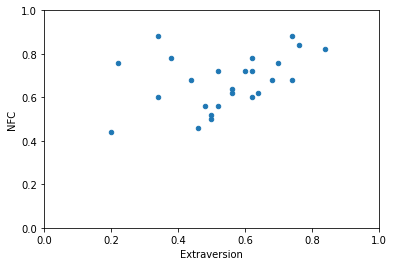

In [69]:
experiment_level_data.plot.scatter(x='Extraversion', y='NFC');
plt.xlim([0, 1])
plt.ylim([0, 1]);
HTML("""
We collected 10 items each for NFC and Extraversion.
We obtained a wider range of Extraversion than NFC.
(Min and max scales normalized to 0 and 1 respectively.)""")

In [65]:
HTML("""When running this experiment, the experiment software was configured to randomize the order
of conditions seen by each subject, not to attempt to counterbalance order.
This was fixed in subsequent experiments."""
     + experiment_level_data.condition_order.value_counts().to_frame().to_html())

,condition_order
"norecs,general,specific",6
"general,norecs,specific",4
"norecs,specific,general",4
"general,specific,norecs",4
"specific,norecs,general",3
"specific,general,norecs",3


In [9]:
def summarize_means(df, by, outcome):
    return ', '.join(f'{name}={group_mean:.2f}' for name, group_mean in df.groupby(by)[outcome].mean().iteritems())

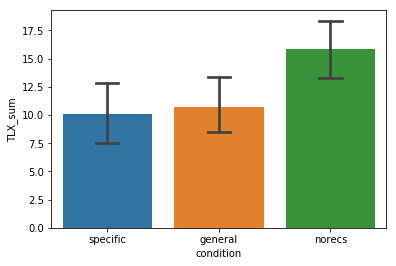

In [9]:
sns.barplot(x='condition', y='TLX_sum', data=block_level_data, capsize=.2)
HTML("The average cognitive load was higher in the no-recommendations condition ({})".format(
    summarize_means(block_level_data, 'condition', 'TLX_sum')))

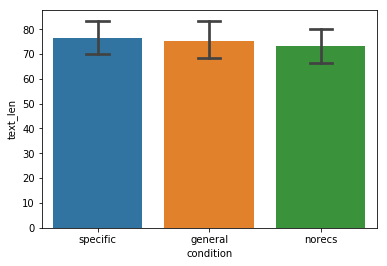

In [10]:
sns.barplot(x='condition', y='text_len', data=trial_level_data, capsize=.2);
HTML("There was no difference in text length between conditions ({}).".format(
    summarize_means(trial_level_data, 'condition', 'text_len')))

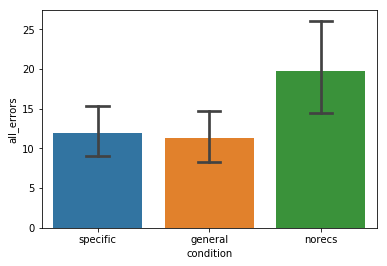

In [11]:
sns.barplot(x='condition', y='all_errors', data=trial_level_data, capsize=.2)
HTML("Participants made more errors (corrected + uncorrected) in the no-recommendations condition ({}).".format(
    summarize_means(trial_level_data, 'condition', 'all_errors')))

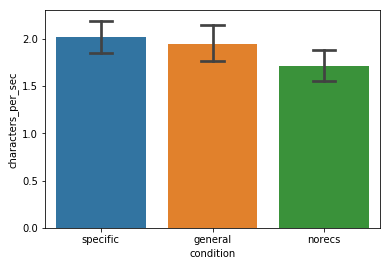

In [12]:
sns.barplot(x='condition', y='characters_per_sec', data=trial_level_data, capsize=.2)
HTML("Participants were slightly faster in the recommendations conditions (characters per second: {}).".format(
    summarize_means(trial_level_data, 'condition', 'characters_per_sec')))

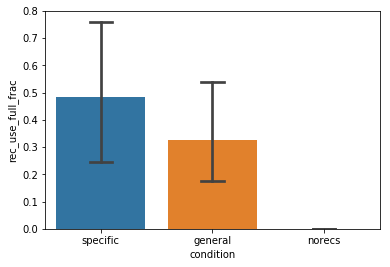

In [19]:
sns.barplot(x='condition', y='rec_use_full_frac', data=trial_level_data, capsize=.2)
HTML("Participants used available recommendations slightly more often when they were specific (use rate: {}).".format(
    summarize_means(trial_level_data, 'condition', 'rec_use_full_frac')))

In [20]:
print('\n\n'.join(x for x in experiment_level_data['techDiff'] if x is not None))

None

None

Mone

No

None

None

No

No issues

No 

No

None

No

No

None

None

Nope

None.

No

None

Just the fact that the third photo in keyboard 1 never loaded.

None

None

None

None

No. 


In [22]:
print('\n\n'.join(x for x in experiment_level_data['other'] if isinstance(x, str)))

No, I really enjoyed this task ☺️

None

None

It went well but my initial survey responses might not be in complete alignment with my final responses on this page.  That's because seeing my captions on this page gave me a better perspective with the benefit of hindsight.  Thanks for the HIT!  I did my best and hope the data is useful!

Being able to not have to backspace to redo typing

None

None

None

None

None

This was very annoying

Everything was great. First and third were pretty equal. Second was awful.

It went smooth no issues 

None

Everything went smoothly. Thank you

Can I type this one on the computer? One: I love the fact that after going to this page straight from the HIT on my computer, the page stayed synced when I went to it from my phone. There are some HITs I've done that could really benefit from that little nicety. Two: I feel like the suggestions really tend toward making me lazy, to some small extent. Having to type it all, you have to think about what to s

In [78]:
writer = pd.ExcelWriter('specificity_details.xlsx')
for stim, group in trial_level_data.groupby('stimulus'):
    group.loc[:,['corrected_text']].to_excel(writer, str(stim))
writer.close()

In [74]:
for stim, txts in trial_level_data.groupby('stimulus').text:
    print()
    print(stim)
    print('\n'.join(txts))
    txts.to_csv(f'{stim}.csv', index=False)


71815
a man with a tennis rackett forcefully swinging at the tennis ball
an adult is holding a tennis racket trying to hit a ball
a tennis player is ready to hit the tennis ball across the court.
a male tennis player in a pink shirt prepares to return a volley in toronto
a male tennis player is on a tennis court with the letters toronto on the mat. the man is swinging his red racket at a yellow tennis ball
a tennis player lunges across the court towards the ball with his tennis racquet.
a tennis player in a white shirt and tan shorts is about to hit back the tennis ball
a tennis player on the court about to swing and hit a ball appproaching him
a tennis player uses his backhand to swing at a tennis ball on a green and blue court
a tennis olayer is ready to hit the ball back to the opponent who is off screen. they are on a professional sponsored court.
a man with a tennis racket, white shirt and shoes holds his racket back in order to hit the ball
a tennis player is swinging his racket